# Training Mars Landmark Identifier Model with Convolutional Neural Network

### Python 2/3 Compatibility Import

In [1]:
### Python 2/3 Compatibility Import
from __future__ import absolute_import, division, print_function, unicode_literals

### Imports

In [43]:
%load_ext tensorboard

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# Helper libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os # for parallelization
import 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
%reload_ext tensorboard

### Load Data

#### Pre-processing Functions

In [3]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [4]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [5]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

#### Declarations

In [11]:
# Mars Landmark Classes
CLASS_NAMES = np.array([
    "other",
    "crater",
    "dark dune",
    "slope streak",
    "bright dune",
    "impact ejecta",
    "swiss cheese",
    "spider",
])

# Image Size
IMG_WIDTH = IMG_HEIGHT = 128
BATCH_SIZE = 32

#### Loading

In [7]:
list_ds = tf.data.Dataset.list_files(str("hirise-map-proj-v3/datasets/*/*"))
labeled_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Image: ", image.numpy())
    print("Label: ", label.numpy())

Image shape:  (128, 128, 3)
Image:  [[[0.45548847 0.45548847 0.45548847]
  [0.4603401  0.4603401  0.4603401 ]
  [0.46400127 0.46400127 0.46400127]
  ...
  [0.48235297 0.48235297 0.48235297]
  [0.4744923  0.4744923  0.4744923 ]
  [0.45882356 0.45882356 0.45882356]]

 [[0.4557905  0.4557905  0.4557905 ]
  [0.46211708 0.46211708 0.46211708]
  [0.4694394  0.4694394  0.4694394 ]
  ...
  [0.4866839  0.4866839  0.4866839 ]
  [0.47267362 0.47267362 0.47267362]
  [0.4476869  0.4476869  0.4476869 ]]

 [[0.45615813 0.45615813 0.45615813]
  [0.4551624  0.4551624  0.4551624 ]
  [0.46248472 0.46248472 0.46248472]
  ...
  [0.4941004  0.4941004  0.4941004 ]
  [0.4810509  0.4810509  0.4810509 ]
  [0.45867038 0.45867038 0.45867038]]

 ...

 [[0.47926742 0.47926742 0.47926742]
  [0.4436998  0.4436998  0.4436998 ]
  [0.42378986 0.42378986 0.42378986]
  ...
  [0.39684242 0.39684242 0.39684242]
  [0.40669852 0.40669852 0.40669852]
  [0.4151107  0.4151107  0.4151107 ]]

 [[0.4640188  0.4640188  0.4640188 ]
 

#### Batching

In [9]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=10000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return ds

In [20]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(8,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [12]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

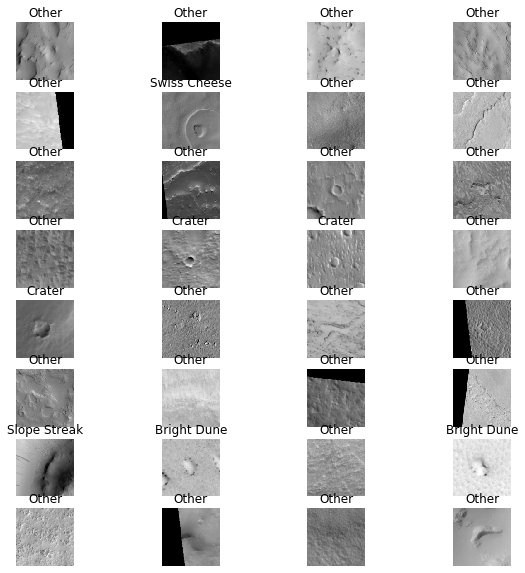

In [21]:
show_batch(image_batch.numpy(), label_batch.numpy())

### Modeling

In [30]:
# CNN Model
model = Sequential(name="MLI_CNN")
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(8, activation="softmax"))

model.summary()

Model: "MLI_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                3211

### Compile & Train

In [38]:
# Compile model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Logs for Tensorboard
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [48]:
# Fitting
MLI_FIT = model.fit(train_ds,
                    epochs=50,
                    steps_per_epoch=100,
                    callbacks=[tensorboard_callback])

model.save("models/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".h5")

Train for 100 steps
Epoch 1/50
100/100 [==============================] - 29s 291ms/step - loss: 0.6788 - accuracy: 0.8300
Epoch 2/50
100/100 [==============================] - 29s 293ms/step - loss: 0.6370 - accuracy: 0.8363
Epoch 3/50
100/100 [==============================] - 34s 344ms/step - loss: 0.5882 - accuracy: 0.8466
Epoch 4/50
100/100 [==============================] - 34s 339ms/step - loss: 0.5870 - accuracy: 0.8394
Epoch 5/50
100/100 [==============================] - 33s 330ms/step - loss: 0.5658 - accuracy: 0.8509
Epoch 6/50
100/100 [==============================] - 32s 322ms/step - loss: 0.5695 - accuracy: 0.8522
Epoch 7/50
100/100 [==============================] - 32s 324ms/step - loss: 0.5734 - accuracy: 0.8422
Epoch 8/50
100/100 [==============================] - 34s 335ms/step - loss: 0.5038 - accuracy: 0.8547
Epoch 9/50
100/100 [==============================] - 32s 324ms/step - loss: 0.4687 - accuracy: 0.8644
Epoch 10/50
100/100 [==============================] 

#### Tensorboard

In [50]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 5868), started 0:40:24 ago. (Use '!kill 5868' to kill it.)

### Evaluate